# Introduction

In [3]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [5]:
%%sql
SELECT *
  FROM sqlite_master
WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


# Overview of the Data

In [6]:
%%sql
SELECT *
FROM facts
LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:

- name - The name of the country.
- area - The total land and sea area of the country.
- population - The country's population.
- population_growth- The country's population growth as a percentage.
birth_rate - The country's birth rate, or the number of births a year per - 1,000 people.
- death_rate - The country's death rate, or the number of death a year per 1,000 people.
- area- The country's total area (both land and water).
- area_land - The country's land area in square kilometers.
- area_water - The country's waterarea in square kilometers.

Let's start by calculating some summary statistics and see what they tell us.

# Summary Statistics

In [7]:
%%sql
SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth)
FROM facts;

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last screen:

- There's a country with a population of 0
- There's a country with a population of 7256490011 (or more than 7.2 billion people)

Let's use subqueries to zoom in on just these countries without using the specific values.

# Exploring Outliers

In [10]:
%%sql
SELECT *
FROM facts
WHERE population = (SELECT MIN(population) FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


It seems like the table contains a row for Antarctica, which explains the population of 0. This seems to match the CIA Factbook page for Antarctica:

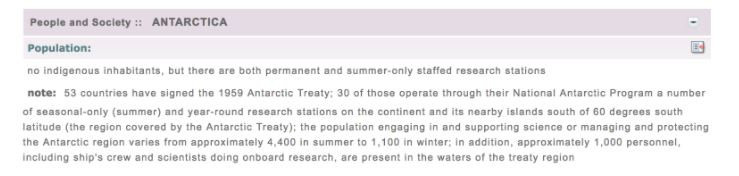

In [11]:
%%sql
SELECT *
FROM facts
WHERE population = (SELECT MAX(population) FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


We also see that the table contains a row for the whole world, which explains the maximum population of over 7.2 billion we found earlier.

Now that we know this, we should recalculate the summary statistics we calculated earlier, while excluding the row for the whole world.

# Summary Statistics Revisited

In [12]:
%%sql
SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth)
FROM facts
WHERE id != 261;

 * sqlite:///factbook.db
Done.


MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,1367485388,0.0,4.02


There's a country whose population closes in on 1.4 billion!

# Exploring Average Population and Area
Let's explore density. Density depends on the population and the country's area. Let's look at the average values for these two columns.

We should take care of discarding the row for the whole planet.

In [16]:
%%sql
SELECT AVG(population), AVG(area)
FROM facts
WHERE id!= 261;

 * sqlite:///factbook.db
Done.


AVG(population),AVG(area)
32242666.56846473,555093.546184739


We see that the average population is around 32 million and the average area is 555 thousand square kilometers.

# Finding Densely Populated Countries

To finish, we'll build on the query above to find countries that are densely populated. We'll identify countries that have:

- Above average values for population.
- Below average values for area.

In [23]:
%%sql
SELECT *
FROM facts
WHERE population > (SELECT AVG(population)
                       FROM facts
                       WHERE id!= 261) 
AND area < (SELECT AVG(area)
                       FROM facts
                       WHERE id!= 261)
AND id!= 261;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
80,iz,Iraq,438317,437367,950,37056169,2.93,31.45,3.77,1.62
83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.1
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.0
120,mo,Morocco,446550,446300,250,33322699,1.0,18.2,4.81,3.36
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
139,pl,Poland,312685,304255,8430,38562189,0.09,9.74,10.19,0.46
163,sp,Spain,505370,498980,6390,48146134,0.89,9.64,9.04,8.31


Some of these countries are generally known to be densely populated, so we have confidence in our results!

## Which country has the most people?

In [28]:
%%sql
SELECT *
FROM facts
WHERE population = (SELECT MAX(population) FROM facts WHERE id!=261);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
37,ch,China,9596960,9326410,270550,1367485388,0.45,12.49,7.53,0.44


China has the highest population in the World with 1367485388 people. (More than 1.3 billion)

## Which country has the highest growth rate?

In [30]:
%%sql
SELECT *
FROM facts
WHERE population_growth	 = (SELECT MAX(population_growth) FROM facts WHERE id!=261);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
162,od,South Sudan,644329,None,None,12042910,4.02,36.91,8.18,11.47


South Sudan has the highest growth rate with 4.02. The country's birth rate is almost 4 times higher than their death rate.

## Which countries have the highest ratios of water to land? Which countries have more water than land?

In [39]:
%%sql 
SELECT name, ROUND(CAST(area_water AS FLOAT) / area_land, 2) AS ratio
FROM facts
ORDER BY CAST(area_water AS FLOAT) / area_land DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,ratio
British Indian Ocean Territory,905.67
Virgin Islands,4.52
Puerto Rico,0.55
"Bahamas, The",0.39
Guinea-Bissau,0.28


British Indian Ocean Territory has the highest ratio with 905.67. Virgin Islands are following with the ratio of 4.52. The two countries have higher ratio than 1. Let's check if they are reallyy the only 2 countries with more area of water than land.

In [40]:
%%sql 
SELECT *
FROM facts
WHERE area_water > area_land;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
228,io,British Indian Ocean Territory,54400,60,54340,None,None,None,None,None
247,vq,Virgin Islands,1910,346,1564,103574,0.59,10.31,8.54,7.67


Yes, we are correct on our exploration. British Indian Ocean Territory and Virgin Islands are the only 2 countries with more water area than land area.

## Which countries will add the most people to their populations next year?

In [42]:
%%sql
SELECT name, birth_rate
FROM facts
ORDER BY birth_rate DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,birth_rate
Niger,45.45
Mali,44.99
Uganda,43.79
Zambia,42.13
Burkina Faso,42.03


Niger, Mali, Uganda, Zambia and Burkina Faso are the top 5 countries with the highest birth rates. They are most likely to add the most people to their populations next year. And it is also interesting that all of the top 5 belong in the Africa continent.

## Which countries have a higher death rate than birth rate?

In [45]:
%%sql
SELECT name, death_rate, birth_rate
FROM facts
WHERE death_rate > birth_rate
ORDER BY death_rate DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,death_rate,birth_rate
Ukraine,14.46,10.72
Bulgaria,14.44,8.92
Latvia,14.31,10.0
Lithuania,14.27,10.1
Russia,13.69,11.6
Serbia,13.66,9.08
Belarus,13.36,10.7
Hungary,12.73,9.16
Moldova,12.59,12.0
Estonia,12.4,10.51


The top 10 countries with higher death rate than their birth rate are shown above. It is interesting that almost all of the countries are Slavic.

## Which countries have the highest population/area?

In [51]:
%%sql
SELECT name,population, area, ROUND(CAST(population AS FLOAT) / area) AS density
FROM facts 
ORDER BY ROUND(CAST(population AS FLOAT) / area) DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.


name,population,area,density
Macau,592731,28,21169.0
Monaco,30535,2,15268.0
Singapore,5674472,697,8141.0
Hong Kong,7141106,1108,6445.0
Gaza Strip,1869055,360,5192.0
Gibraltar,29258,6,4876.0
Bahrain,1346613,760,1772.0
Maldives,393253,298,1320.0
Malta,413965,316,1310.0
Bermuda,70196,54,1300.0


The top 10 countries with the highest ratio of population over area are shown above.

# CONCLUSIONS

We have discovered many aspects for the dataset from the CIA countries of the world.

We have answered many questions to find out the top countries such as the highest populated, China, to Niger with the highest birth rate ratios. 

We have also shown top countries for population densities.